**Library Imports**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import timedelta
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             f1_score, precision_recall_curve, roc_auc_score)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


**Data Loading**

In [5]:
users_df = pd.read_csv('data/users.csv')
purchases_df = pd.read_csv('data/purchases.csv')

**Data Exploration and Overview**

In [7]:
pd.set_option('display.width', 1000)  # expand display
pd.set_option('display.max_columns', None)  # show all columns

# For users_df
print("##################### df_level_start ############")
print("##################### Shape #####################")
print(users_df.shape)
print("##################### Types #####################")
print(users_df.dtypes)
print("##################### Head #####################")
print(users_df.head())
print("##################### Tail #####################")
print(users_df.tail())
print("##################### NA #####################")
print(users_df.isnull().sum())

# For purchases_df
print("##################### df_level_end ############")
print("##################### Shape #####################")
print(purchases_df.shape)
print("##################### Types #####################")
print(purchases_df.dtypes)
print("##################### Head #####################")
print(purchases_df.head())
print("##################### Tail #####################")
print(purchases_df.tail())
print("##################### NA #####################")
print(purchases_df.isnull().sum())


##################### df_level_start ############
##################### Shape #####################
(105743, 4)
##################### Types #####################
user_id              int64
join_date           object
operating_system    object
country             object
dtype: object
##################### Head #####################
   user_id   join_date operating_system               country
0        1  2023-07-20              NaN                   NaN
1        2  2023-07-20              iOS         United States
2        3  2023-07-20              iOS  United Arab Emirates
3        4  2023-07-20          Android                Canada
4        5  2023-07-20          Android           Philippines
##################### Tail #####################
        user_id   join_date operating_system       country
105738   105739  2023-06-17          Android     Indonesia
105739   105740  2023-02-07              iOS        Canada
105740   105741  2023-07-27          Android     Indonesia
105741   1

In [8]:
purchases_df['user_id'].nunique()

9515

In [9]:
# Time adjustment for accuracy and error prevention in record review
purchases_df['purchase_timestamp'] = pd.to_datetime(purchases_df['purchase_timestamp'], unit='us')
purchases_df

,user_id,purchase_timestamp,purchase_amount
0,70118,2023-08-12 02:14:18.591073,2.6595
1,75341,2023-08-12 11:35:42.897945,2.7715
2,56594,2023-08-12 12:09:06.981972,1.6745
3,72659,2023-08-12 06:13:10.221024,2.3640
4,73903,2023-08-12 18:35:29.709843,4.3930
...,...,...,...
47442,8793,2023-08-13 00:46:29.992706,1.8905
47443,37640,2023-08-21 20:51:22.517039,11.9880
47444,40873,2023-08-19 19:46:23.769783,8.4915
47445,10641,2023-08-01 09:29:34.644781,2.2885


**DATA MANIPULATION**

**Merge Dataframes**

In [12]:
#Merge purchase_df and users_df
purchases_df = pd.merge(purchases_df, users_df, on='user_id', how='left')
purchases_df

,user_id,purchase_timestamp,purchase_amount,join_date,operating_system,country
0,70118,2023-08-12 02:14:18.591073,2.6595,2023-08-10,iOS,Australia
1,75341,2023-08-12 11:35:42.897945,2.7715,2023-08-12,Android,United Kingdom
2,56594,2023-08-12 12:09:06.981972,1.6745,2023-08-06,iOS,Australia
3,72659,2023-08-12 06:13:10.221024,2.3640,2023-08-11,iOS,Australia
4,73903,2023-08-12 18:35:29.709843,4.3930,2023-08-11,iOS,United Kingdom
...,...,...,...,...,...,...
47442,8793,2023-08-13 00:46:29.992706,1.8905,2023-07-22,Android,Australia
47443,37640,2023-08-21 20:51:22.517039,11.9880,2023-07-30,iOS,United States
47444,40873,2023-08-19 19:46:23.769783,8.4915,2023-08-01,iOS,United States
47445,10641,2023-08-01 09:29:34.644781,2.2885,2023-07-22,Android,United States


In [13]:
#Drop nulls
purchases_df.dropna(inplace=True)
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47081 entries, 0 to 47446
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             47081 non-null  int64         
 1   purchase_timestamp  47081 non-null  datetime64[ns]
 2   purchase_amount     47081 non-null  float64       
 3   join_date           47081 non-null  object        
 4   operating_system    47081 non-null  object        
 5   country             47081 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.5+ MB


In [14]:
# Convert 'join_date' and 'purchase_timestamp' columns to datetime type
purchases_df['join_date'] = pd.to_datetime(purchases_df['join_date'])
purchases_df['purchase_timestamp'] = pd.to_datetime(purchases_df['purchase_timestamp'])

**Feature Engineering**

Create Target Column

In [17]:
# Initialize a new column in the purchase data to store the target for each purchase
purchases_df['purchase_within_3_days'] = 0

# Sort purchases by user_id and timestamp for proper window calculations
purchases_df = purchases_df.sort_values(['user_id', 'purchase_timestamp']).reset_index(drop=True)

# Loop through each purchase record and check for another purchase within the next 3 days
for idx, row in purchases_df.iterrows():
    user_id = row['user_id']
    purchase_time = row['purchase_timestamp']

    # Define the 3-day window for the current purchase
    window_end_time = purchase_time + timedelta(days=3)

    # Check if there's another purchase within this window for the same user
    future_purchases = purchases_df[(purchases_df['user_id'] == user_id) &
                                    (purchases_df['purchase_timestamp'] > purchase_time) &
                                    (purchases_df['purchase_timestamp'] <= window_end_time)]
    
    # If there is at least one future purchase in the 3-day window, mark target as 1
    if not future_purchases.empty:
        purchases_df.at[idx, 'purchase_within_3_days'] = 1

purchases_df.head()

,user_id,purchase_timestamp,purchase_amount,join_date,operating_system,country,purchase_within_3_days
0,84,2023-07-28 00:00:13.302076,2.4875,2023-07-20,iOS,United States,0
1,84,2023-08-01 02:08:06.306270,9.5880,2023-07-20,iOS,United States,0
2,84,2023-08-04 04:31:01.035343,13.4865,2023-07-20,iOS,United States,0
3,158,2023-07-27 11:54:27.277803,16.3755,2023-07-20,iOS,Türkiye,1
4,158,2023-07-27 13:34:52.606424,23.0375,2023-07-20,iOS,Türkiye,1


Calculate and add days since join information

In [19]:
# Calculate the difference in days and add as a new column
purchases_df['days_since_join'] = (purchases_df['purchase_timestamp'] - purchases_df['join_date']).dt.days
purchases_df

,user_id,purchase_timestamp,purchase_amount,join_date,operating_system,country,purchase_within_3_days,days_since_join
0,84,2023-07-28 00:00:13.302076,2.4875,2023-07-20,iOS,United States,0,8
1,84,2023-08-01 02:08:06.306270,9.5880,2023-07-20,iOS,United States,0,12
2,84,2023-08-04 04:31:01.035343,13.4865,2023-07-20,iOS,United States,0,15
3,158,2023-07-27 11:54:27.277803,16.3755,2023-07-20,iOS,Türkiye,1,7
4,158,2023-07-27 13:34:52.606424,23.0375,2023-07-20,iOS,Türkiye,1,7
...,...,...,...,...,...,...,...,...
47076,105038,2023-08-21 04:54:49.951980,37.4875,2023-08-20,iOS,United States,1,1
47077,105038,2023-08-21 05:48:04.230952,32.9890,2023-08-20,iOS,United States,0,1
47078,105039,2023-08-20 23:51:33.580873,43.9890,2023-08-20,Android,United States,1,0
47079,105039,2023-08-21 01:37:55.452321,37.4875,2023-08-20,Android,United States,1,1


Add total purchases before and total bought amount 

In [21]:
# Calculate the total number of purchases for each user
purchases_df['total_purchases_before'] = purchases_df.groupby('user_id').cumcount()

# Calculate the total amount spent for each user
purchases_df['total_bought_amount'] = purchases_df.groupby('user_id')['purchase_amount'].cumsum() 

purchases_df.head()

,user_id,purchase_timestamp,purchase_amount,join_date,operating_system,country,purchase_within_3_days,days_since_join,total_purchases_before,total_bought_amount
0,84,2023-07-28 00:00:13.302076,2.4875,2023-07-20,iOS,United States,0,8,0,2.4875
1,84,2023-08-01 02:08:06.306270,9.5880,2023-07-20,iOS,United States,0,12,1,12.0755
2,84,2023-08-04 04:31:01.035343,13.4865,2023-07-20,iOS,United States,0,15,2,25.5620
3,158,2023-07-27 11:54:27.277803,16.3755,2023-07-20,iOS,Türkiye,1,7,0,16.3755
4,158,2023-07-27 13:34:52.606424,23.0375,2023-07-20,iOS,Türkiye,1,7,1,39.4130


Add number of days since last purchase(purchase gap between last)

In [23]:
# Calculate the number of days since the last purchase for each user
purchases_df['days_since_last_purchase'] = purchases_df.groupby('user_id')['purchase_timestamp'].diff().dt.days.fillna(0)
purchases_df.head()

,user_id,purchase_timestamp,purchase_amount,join_date,operating_system,country,purchase_within_3_days,days_since_join,total_purchases_before,total_bought_amount,days_since_last_purchase
0,84,2023-07-28 00:00:13.302076,2.4875,2023-07-20,iOS,United States,0,8,0,2.4875,0.0
1,84,2023-08-01 02:08:06.306270,9.5880,2023-07-20,iOS,United States,0,12,1,12.0755,4.0
2,84,2023-08-04 04:31:01.035343,13.4865,2023-07-20,iOS,United States,0,15,2,25.5620,3.0
3,158,2023-07-27 11:54:27.277803,16.3755,2023-07-20,iOS,Türkiye,1,7,0,16.3755,0.0
4,158,2023-07-27 13:34:52.606424,23.0375,2023-07-20,iOS,Türkiye,1,7,1,39.4130,0.0


Add average bought amount 

In [25]:
purchases_df["avg_bought_amount"] = purchases_df["total_bought_amount"] / (purchases_df["total_purchases_before"] + 1)
purchases_df.head()

,user_id,purchase_timestamp,purchase_amount,join_date,operating_system,country,purchase_within_3_days,days_since_join,total_purchases_before,total_bought_amount,days_since_last_purchase,avg_bought_amount
0,84,2023-07-28 00:00:13.302076,2.4875,2023-07-20,iOS,United States,0,8,0,2.4875,0.0,2.487500
1,84,2023-08-01 02:08:06.306270,9.5880,2023-07-20,iOS,United States,0,12,1,12.0755,4.0,6.037750
2,84,2023-08-04 04:31:01.035343,13.4865,2023-07-20,iOS,United States,0,15,2,25.5620,3.0,8.520667
3,158,2023-07-27 11:54:27.277803,16.3755,2023-07-20,iOS,Türkiye,1,7,0,16.3755,0.0,16.375500
4,158,2023-07-27 13:34:52.606424,23.0375,2023-07-20,iOS,Türkiye,1,7,1,39.4130,0.0,19.706500


Add purchase day(What day of the week was the purchase made?) information

In [27]:
# Adding the 'day_of_week' feature based on the purchase timestamp to see its distribution with purchase_within_3_days
purchases_df['day_of_week'] = purchases_df['purchase_timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
purchases_df.head()

,user_id,purchase_timestamp,purchase_amount,join_date,operating_system,country,purchase_within_3_days,days_since_join,total_purchases_before,total_bought_amount,days_since_last_purchase,avg_bought_amount,day_of_week
0,84,2023-07-28 00:00:13.302076,2.4875,2023-07-20,iOS,United States,0,8,0,2.4875,0.0,2.487500,4
1,84,2023-08-01 02:08:06.306270,9.5880,2023-07-20,iOS,United States,0,12,1,12.0755,4.0,6.037750,1
2,84,2023-08-04 04:31:01.035343,13.4865,2023-07-20,iOS,United States,0,15,2,25.5620,3.0,8.520667,4
3,158,2023-07-27 11:54:27.277803,16.3755,2023-07-20,iOS,Türkiye,1,7,0,16.3755,0.0,16.375500,3
4,158,2023-07-27 13:34:52.606424,23.0375,2023-07-20,iOS,Türkiye,1,7,1,39.4130,0.0,19.706500,3


Filter Recent Purchase Records: Retain Last Purchases Within Three Days of Latest Purchase

In [29]:
# 1. Find the most recent purchase timestamp in the DataFrame
latest_timestamp = purchases_df['purchase_timestamp'].max()

# 2. Select the last purchase record for each user
last_purchases_df = purchases_df.sort_values(['user_id', 'purchase_timestamp']).groupby('user_id').tail(1)

# 3. Filter the last purchase records up to three days before the overall most recent date
three_days_before_latest = latest_timestamp - timedelta(days=3)
to_delete_indexes = last_purchases_df[last_purchases_df['purchase_timestamp'] < three_days_before_latest].index

# 4. Remove these records from purchases_df
purchases_df = purchases_df.drop(index=to_delete_indexes).reset_index(drop=True)

# Display the resulting DataFrame
purchases_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40356 entries, 0 to 40355
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_id                   40356 non-null  int64         
 1   purchase_timestamp        40356 non-null  datetime64[ns]
 2   purchase_amount           40356 non-null  float64       
 3   join_date                 40356 non-null  datetime64[ns]
 4   operating_system          40356 non-null  object        
 5   country                   40356 non-null  object        
 6   purchase_within_3_days    40356 non-null  int64         
 7   days_since_join           40356 non-null  int64         
 8   total_purchases_before    40356 non-null  int64         
 9   total_bought_amount       40356 non-null  float64       
 10  days_since_last_purchase  40356 non-null  float64       
 11  avg_bought_amount         40356 non-null  float64       
 12  day_of_week       

**Visualization of Features**

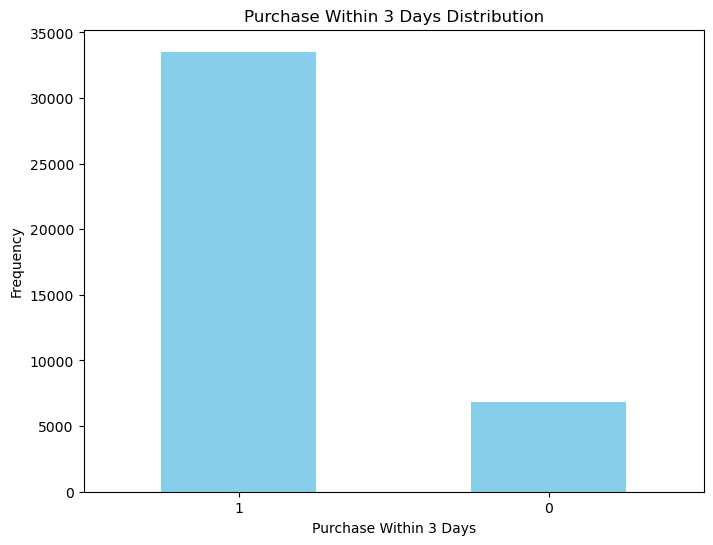

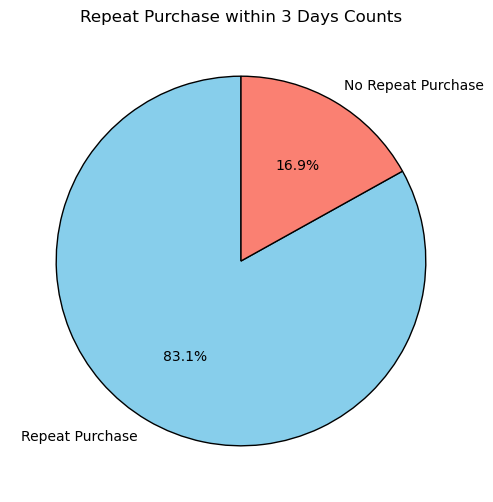

In [31]:
#counts of values 
value_counts = purchases_df['purchase_within_3_days'].value_counts()
# Plot bar graph the value counts
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Purchase Within 3 Days Distribution')
plt.xlabel('Purchase Within 3 Days')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.show()

# Plot the proportion of purchases with a repeat within 3 days (Pie Chart)
plt.figure(figsize=(6, 6))
purchases_df['purchase_within_3_days'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', labels=['Repeat Purchase', 'No Repeat Purchase'],
    colors=['skyblue', 'salmon'], startangle=90, wedgeprops={'edgecolor': 'black'}
)
plt.title('Repeat Purchase within 3 Days Counts')
plt.ylabel('')  # Hide the default y-axis label
plt.show()



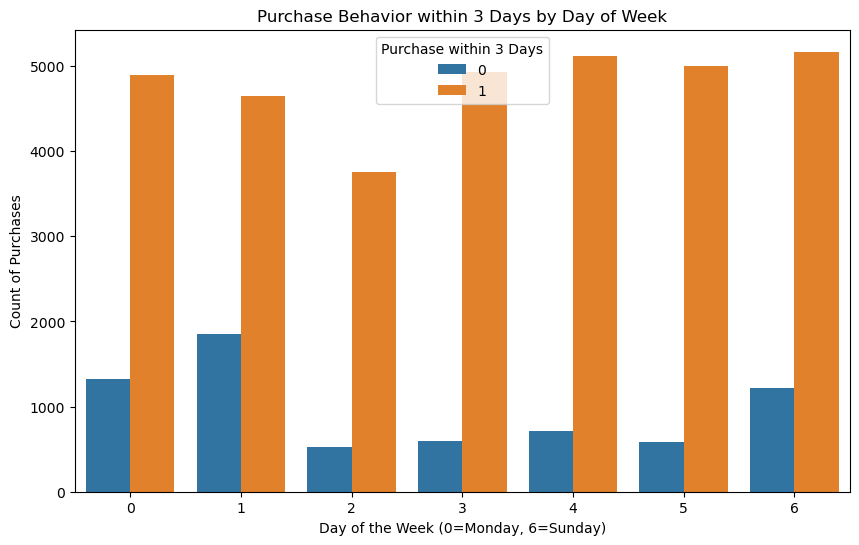

In [32]:
# Plot the relationship between day_of_week and purchase_within_3_days to observe if there is any trend
plt.figure(figsize=(10, 6))
sns.countplot(data=purchases_df, x='day_of_week', hue='purchase_within_3_days')
plt.title("Purchase Behavior within 3 Days by Day of Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Count of Purchases")
plt.legend(title="Purchase within 3 Days")
plt.show()

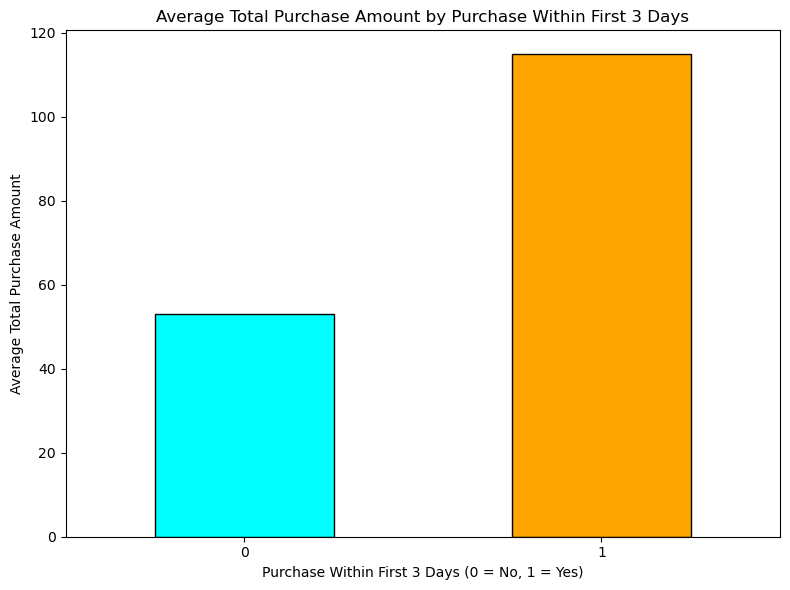

In [33]:
# Group by purchase_within_3_days and calculate average total_bought_amount
purchase_within_3_days_total_purchase = purchases_df.groupby('purchase_within_3_days')['total_bought_amount'].mean()

# Plotting
plt.figure(figsize=(8, 6))
purchase_within_3_days_total_purchase.plot(kind='bar', color=['cyan', 'orange'], edgecolor='black')
plt.xlabel('Purchase Within First 3 Days (0 = No, 1 = Yes)')
plt.ylabel('Average Total Purchase Amount')
plt.title('Average Total Purchase Amount by Purchase Within First 3 Days')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

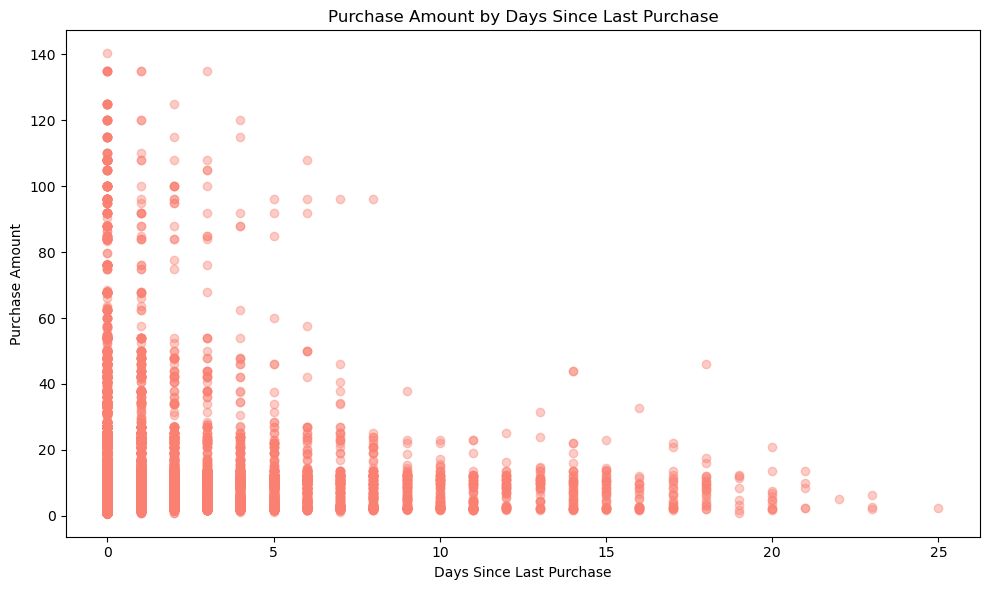

In [34]:
# Scatter plot of days_since_last_purchase vs. purchase_amount
plt.figure(figsize=(10, 6))
plt.scatter(purchases_df['days_since_last_purchase'], purchases_df['purchase_amount'], alpha=0.4, color='salmon')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Purchase Amount')
plt.title('Purchase Amount by Days Since Last Purchase')
plt.tight_layout()
plt.show()

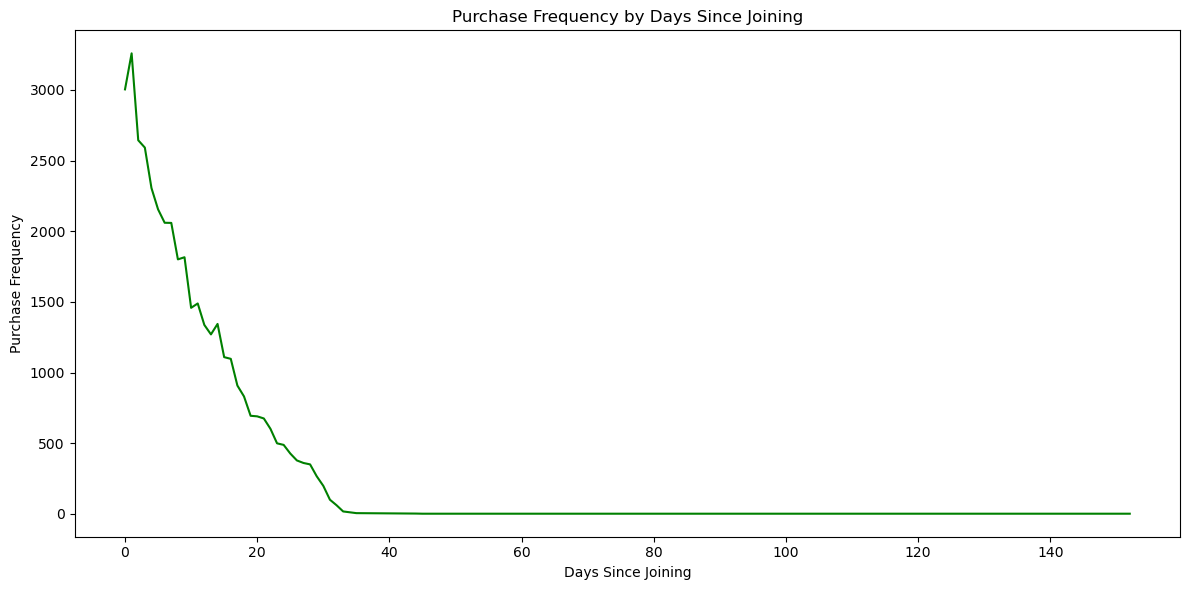

In [35]:
# Group by days_since_join and count the occurrences to see purchase frequency
days_since_join_freq = purchases_df['days_since_join'].value_counts().sort_index()

# Plotting purchase frequency based on days since joining
plt.figure(figsize=(12, 6))
plt.plot(days_since_join_freq.index, days_since_join_freq.values, color='green')
plt.xlabel('Days Since Joining')
plt.ylabel('Purchase Frequency')
plt.title('Purchase Frequency by Days Since Joining')
plt.tight_layout()
plt.show()

**MODELS**

**Finding The Most Suitable Model**

Split data into training and test sets

In [39]:
# Define features and target variable
X = purchases_df[['purchase_amount', 'days_since_join', 'total_purchases_before',
                  'total_bought_amount','days_since_last_purchase','avg_bought_amount','day_of_week']]
y = purchases_df['purchase_within_3_days']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display shapes of the resulting datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32284, 7), (8072, 7), (32284,), (8072,))

RANDOM FOREST MODEL

Includes hyperparameter optimization using RandomizedSearchCV

In [42]:
# Define parameter ranges
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter optimization using RandomizedSearchCV
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=50, 
                                      cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random_search.fit(X_train, y_train)

# Get the best model
best_rf_model = rf_random_search.best_estimator_
best_rf_model

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

In [43]:
# Make predictions on the test set
y_pred_best_rf = best_rf_model.predict(X_test)
y_pred_proba_best_rf = best_rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate model performance
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_pred_proba_best_rf)
classification_rep_best_rf = classification_report(y_test, y_pred_best_rf)

# Print the results
print("### Best Random Forest Model Performance ###\n")
print(f"Accuracy: {accuracy_best_rf * 100:.2f}%")
print(f"F1 Score: {f1_best_rf * 100:.2f}%")
print(f"ROC-AUC: {roc_auc_best_rf * 100:.2f}%\n")

print("### Detailed Classification Report ###\n")
print(classification_rep_best_rf)

# Feature importance
# purchase_amount: 0.1833
# days_since_join: 0.1240
# total_purchases_before: 0.1326
# total_bought_amount: 0.2419
# days_since_last_purchase: 0.1058
# operating_system: 0.0150 (so this feature was excluded)
# avg_bought_amount: 0.1973

### Best Random Forest Model Performance ###

Accuracy: 83.51%
F1 Score: 90.91%
ROC-AUC: 75.10%

### Detailed Classification Report ###

              precision    recall  f1-score   support

           0       0.60      0.06      0.11      1358
           1       0.84      0.99      0.91      6714

    accuracy                           0.84      8072
   macro avg       0.72      0.53      0.51      8072
weighted avg       0.80      0.84      0.77      8072



LOGISTIC REGRESSION MODEL

Includes finding the best hyperparameters with GridSearchCV

In [46]:
# Hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

# Finding the best hyperparameters with GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model
best_log_reg = grid_search.best_estimator_

# Make predictions on the test set
y_pred_log_reg = best_log_reg.predict(X_test)
y_pred_proba_log_reg = best_log_reg.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)
roc_auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg)
classification_rep_log_reg = classification_report(y_test, y_pred_log_reg)

# Display model performance in a more readable format
print("### Model Performance ###\n")
print(f"Accuracy: {accuracy_log_reg * 100:.2f}%")
print(f"F1 Score: {f1_log_reg * 100:.2f}%")
print(f"ROC-AUC: {roc_auc_log_reg * 100:.2f}%\n")

print("### Detailed Classification Report ###\n")
print(classification_rep_log_reg)

### Model Performance ###

Accuracy: 83.18%
F1 Score: 90.77%
ROC-AUC: 70.25%

### Detailed Classification Report ###

              precision    recall  f1-score   support

           0       0.50      0.02      0.05      1358
           1       0.83      1.00      0.91      6714

    accuracy                           0.83      8072
   macro avg       0.67      0.51      0.48      8072
weighted avg       0.78      0.83      0.76      8072



XGBOOST MODEL

In [48]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balancing data with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

# Display model performance in a more readable format
print("### Model Performance ###\n")
print(f"Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"F1 Score: {f1_xgb * 100:.2f}%")
print(f"ROC-AUC: {roc_auc_xgb * 100:.2f}%\n")

print("### Detailed Classification Report ###\n")
print(classification_rep_xgb)

### Model Performance ###

Accuracy: 80.62%
F1 Score: 88.66%
ROC-AUC: 72.87%

### Detailed Classification Report ###

              precision    recall  f1-score   support

           0       0.40      0.29      0.34      1358
           1       0.86      0.91      0.89      6714

    accuracy                           0.81      8072
   macro avg       0.63      0.60      0.61      8072
weighted avg       0.79      0.81      0.79      8072



C:\Users\Baran\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


**AUC-PR Graph**

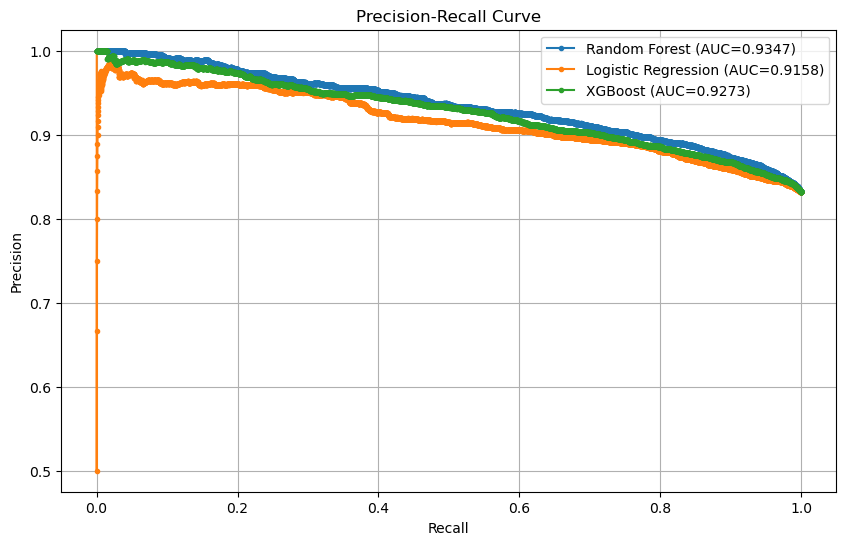

In [50]:
# Define a function to plot AUC-PR
def plot_auc_pr(y_true, y_scores, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_pr = auc(recall, precision)
    
    plt.plot(recall, precision, marker='.', label=f'{model_name} (AUC={auc_pr:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    return auc_pr

# Plot the AUC-PR graph
plt.figure(figsize=(10, 6))

# AUC-PR for Random Forest
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]  # Random Forest probabilities
plot_auc_pr(y_test, y_pred_proba_rf, 'Random Forest')

# AUC-PR for Logistic Regression
y_pred_proba_log_reg = best_log_reg.predict_proba(X_test)[:, 1]  # Logistic Regression probabilities
plot_auc_pr(y_test, y_pred_proba_log_reg, 'Logistic Regression')

# AUC-PR for XGBoost
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]  # XGBoost probabilities
plot_auc_pr(y_test, y_pred_proba_xgb, 'XGBoost')

# Show the plot
plt.show()

**LSTM Model**

In [52]:
selected_features = ['user_id', 'purchase_amount', 'total_purchases_before', 'days_since_join',
                     'total_bought_amount', 'days_since_last_purchase', 
                     'avg_bought_amount', 'day_of_week', 'purchase_within_3_days']
df_selected = purchases_df[selected_features]

In [53]:
# Create sequences per user (Sequence Length: 5)
sequence_length = 5
sequences = []
targets = []

for user_id, user_data in df_selected.groupby('user_id'):
    user_data_values = user_data[['purchase_amount', 'total_purchases_before', 'days_since_join',
                                  'total_bought_amount', 'days_since_last_purchase', 
                                  'avg_bought_amount', 'day_of_week']].values
    target_values = user_data['purchase_within_3_days'].values

    for i in range(len(user_data_values) - sequence_length):
        sequence = user_data_values[i:i + sequence_length]
        target = target_values[i + sequence_length]

        sequences.append(sequence)
        targets.append(target)


Z = np.array(sequences)
t = np.array(targets)


In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Initialize the model
model = Sequential()

# First LSTM layer with fewer neurons
model.add(LSTM(256, input_shape=(Z.shape[1], Z.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))

# Fourth LSTM layer
model.add(LSTM(32))
model.add(Dropout(0.3))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Class weights to emphasize Class 0
class_weights = {0: 5.0, 1: 1.0}

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
#arly_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with a larger batch size and reduced epochs
history = model.fit(Z, t, epochs=200, batch_size=16, validation_split=0.2,
                    class_weight=class_weights)#, callbacks=[early_stopping])

# Evaluate the model’s performance
t_pred = (model.predict(Z) > 0.5).astype("int32")

# Generate a classification report
report = classification_report(t, t_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

# Print the full classification report for detailed metrics
print(classification_report(t, t_pred, target_names=['Class 0', 'Class 1']))

# Extract overall F1 score (macro and weighted averages)
macro_f1 = report['macro avg']['f1-score']
weighted_f1 = report['weighted avg']['f1-score']

print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Epoch 1/200


C:\Users\Baran\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1061/1061 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8100 - loss: 0.8725 - val_accuracy: 0.8593 - val_loss: 0.4285
Epoch 2/200
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7836 - loss: 0.8683 - val_accuracy: 0.8619 - val_loss: 0.4107
Epoch 3/200
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7857 - loss: 0.8578 - val_accuracy: 0.8377 - val_loss: 0.4450
Epoch 4/200
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7975 - loss: 0.8479 - val_accuracy: 0.8551 - val_loss: 0.4241
Epoch 5/200
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7715 - loss: 0.8375 - val_accuracy: 0.8678 - val_loss: 0.3824
Epoch 6/200
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7939 - loss: 0.8388 - val_accuracy: 0.8808 - val_loss: 0.3645
Epoch 7/200
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8057 - loss: 0.8360 - val_accuracy: 0.8457 - val_loss: 0.4266
Epoch 8/200
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8077 - loss: 0.8294 - val

One of the previous examples is provided below. This indicates that better results can be achieved by optimizing the LSTM parameters.

              precision    recall  f1-score   support

     Class 0       0.36      0.52      0.43      2232
     Class 1       0.94      0.89      0.92     18986

    accuracy                           0.85     21218
   macro avg       0.65      0.71      0.67     21218
weighted avg       0.88      0.85      0.86     21218

Macro F1 Score: 0.6710
Weighted F1 Score: 0.8637

epoch = 50 batch_size = 32